In [4]:
from copy import deepcopy
from dataclasses import dataclass
import os

import flamedisx as fd
import matplotlib
import matplotlib.pyplot as plt
from multihist import Hist1d, Histdd, poisson_1s_interval
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import tensorflow as tf
from tqdm.notebook import tqdm

class LowMassWIMPSource(fd.SR0WIMPSource):
    mw = 30  # GeV
    
max_sigma = 3

@dataclass
class Template:
    events_per_bin: Histdd
    n_trials: int
    mu_before_efficiencies: float
    
    @property
    def differential_rate(self):
        return self.events_per_bin * self.events_to_diffrate

    @property
    def events_to_diffrate(self):
        # Convert to PDF
        # Multiply by total expected event rate
        # (from the source, i.e. before correcting for efficiencies)
        # The efficiency is correctly taken into account because we divide by 
        # the number of trials above, not the number of observed events.
        return self.mu_before_efficiencies / (
            self.events_per_bin.bin_volumes() * self.n_trials)
    
    def plot(self):
        mh = self.differential_rate
        mh.plot(cblabel=r'$\mu \times \mathrm{PDF}$')
        std_axes()
    
    
fn = 'dsets_dump.pkl'
if os.path.exists(fn):
    with open(fn, mode='rb') as f:
        dsets = pickle.load(f)
else:
    dsets = dict()

dsets['er']['source'] = fd.SR0ERSource(max_sigma=max_sigma)
dsets['nr']['source'] = LowMassWIMPSource(max_sigma=max_sigma)

In [5]:
def logticks(tmin, tmax=None, tick_at=None):
    if tick_at is None:
        tick_at = (1, 2, 5, 10)
    a, b = np.log10([tmin, tmax])
    a = np.floor(a)
    b = np.ceil(b)
    ticks = np.sort(np.unique(np.outer(
        np.array(tick_at), 
        10.**np.arange(a, b)).ravel()))
    ticks = ticks[(tmin <= ticks) & (ticks <= tmax)]
    return ticks

def log_x(a=None, b=None, scalar_ticks=True, tick_at=None):
    plt.xscale('log')
    if a is not None:
        if b is None:
            a, b = a[0], a[-1]
        plt.xlim(a, b)
        ax = plt.gca()
        if scalar_ticks:
            ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
            ax.set_xticks(logticks(a, b, tick_at))        
    
def log_y(a=None, b=None, scalar_ticks=True, tick_at=None):
    plt.yscale('log')
    if a is not None:
        if b is None:
            a, b = a[0], a[-1]
        ax = plt.gca()
        plt.ylim(a, b)
        if scalar_ticks:
            ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
            ax.set_yticks(logticks(a, b, tick_at))

In [6]:
s1_bounds = (2, 70)
s2_bounds = (200, 6000)


def std_axes():
    plt.xlim(*s1_bounds)
    plt.ylim(*s2_bounds)
    plt.xlabel("S1 [PE]")
    plt.ylabel("S2 [PE]")
    log_x(*s1_bounds, tick_at=[1, 2, 3, 5, 7,])
    log_y(*s2_bounds, tick_at=[1, 2, 3, 5, 7,])
    

fix_truth = dict(x=0, y=0, z=-50,
                 event_time=1.58313768e+18,  # (t_start + t_stop)/2
                 drift_time=374531.8352059925
                )   # NB: this gets modified! Surprise!
        
def make_template(source, n_trials, resolution,):
    trials_per_batch = min(int(1e5), n_trials)

    mh = Histdd(bins=(
        np.geomspace(*s1_bounds, num=resolution + 1),
        np.geomspace(*s2_bounds, num=resolution + 1)))
    
    n_batches = n_trials // trials_per_batch
    
    for _ in tqdm(range(n_batches)):
        _d = source.simulate(trials_per_batch,
                             fix_truth=fix_truth)
        mh.add(_d['s1'], _d['s2'])
        
    return Template(events_per_bin=mh,
                    n_trials=n_trials,
                    mu_before_efficiencies=source.mu_before_efficiencies())

In [7]:
for dname, q in dsets.items():
    fn = f'big_{dname}_template.pkl'
    if os.path.exists(fn):
        with open(fn, mode='rb') as f:
            q['template'] = pickle.load(f)
    else:
        t = q['template'] = make_template(dsets[dname]['source'], int(1e8), 70)
        with open(fn, mode='wb') as f:
            pickle.dump(t, f)
    q['mh_diff_rate'] = q['template'].differential_rate.histogram.ravel()

Create flamedisx dataset with events at the bin centers

In [8]:
# These are the same for all templates
mh = dsets['er']['template'].differential_rate
_s1, _s2 = np.stack(np.meshgrid(*mh.bin_centers(), indexing='ij'))
ds1 = (np.diff(mh.bin_edges[0])[:, None] * np.ones_like(_s1)).ravel()
ds2 = (np.diff(mh.bin_edges[1])[None, :] * np.ones_like(_s1)).ravel()
s1 = _s1.ravel()
s2 = _s2.ravel()

# Check we didn't mess up the order (e.g. by forgetting indexing='ij')
# Works best at low resolution / n of bins
# t.plot()
# plt.scatter(s1, s2, c=mh.histogram.ravel(), s=40, edgecolors='w')

In [9]:
# s = dsets['nr']['source']
# (s.t_start.value + s.t_stop.value) / 2

In [10]:
def get_fd_dr(source, s1, s2):
    df = pd.DataFrame(dict(s1=s1, 
                           s2=s2, 
                           **fix_truth,
                           x_observed=fix_truth['x'],
                           y_observed=fix_truth['y']))
    source.set_data(df)
    return source.batched_differential_rate()

for dname, q in dsets.items():
    q['fd_diff_rate'] = get_fd_dr(q['source'], s1, s2)

100%|██████████| 490/490 [01:00<00:00,  8.07it/s]


Flamedisx computes differential rates at exact locations; the template averages over a bin.

To estimate the relative difference between these, compare
  * flamedisx differential rates at the bin center
  * average of flamedisx differential rates at the four bin corners.

(Well, half width of bin added or subtracted. Since the binning isn't uniform we're not exactly looking at the corners.)

In [ ]:
for dname, q in dsets.items():
    corner_results = []
    for s1_sign in [-1, 1]:
        for s2_sign in [-1, 1]:
            corner_results.append(get_fd_dr(
                q['source'],
                (s1 + s1_sign * ds1/2).clip(s1_bounds[0] + 0.01, s1_bounds[1]),
                (s2 + s2_sign * ds2/2).clip(s2_bounds[0] + 0.01, s2_bounds[1])))
    q['fd_diff_rate_corners'] = np.mean(corner_results, axis=0)

In [ ]:
for dname, q in dsets.items():
    q['binning_error'] = ((q['fd_diff_rate_corners'] - q['fd_diff_rate']) 
                          / (0.5 * (q['fd_diff_rate_corners'] + q['fd_diff_rate'])))

There is also a statistical error on the template. I'll use a relative error of 1/sqrt(1+n). It's not great, but I need something symmetric and relative that I can add in quadrature to the other error.

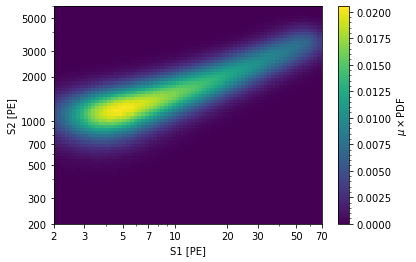

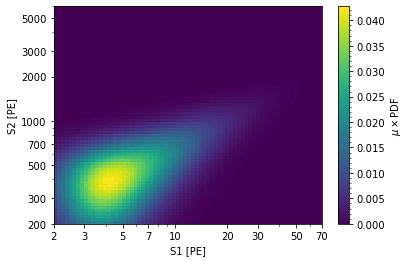

In [11]:
for dname, q in dsets.items():
    t = q['template']
    t.plot()
    plt.show()
    q['mh_epb'] = t.events_per_bin.histogram.ravel()
    q['stat_error'] = (q['mh_epb'] + 1)**-0.5
    q['total_error'] = (q['stat_error']**2 + q['binning_error']**2)**0.5

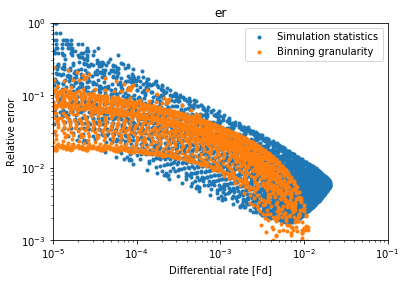

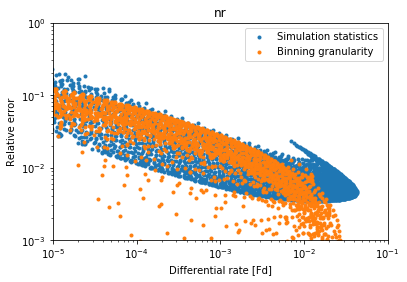

In [12]:
for dname, q in dsets.items():
    plt.scatter(q['fd_diff_rate'], q['stat_error'], marker='.', label='Simulation statistics')
    plt.scatter(q['fd_diff_rate'], q['binning_error'], marker='.', label='Binning granularity')
    #plt.scatter(fd_diff_rate, stat_error, marker='.', label='Total')
    plt.legend(loc='best')
    plt.xscale('log')
    plt.xlim(1e-5, 1e-1)
    plt.yscale('log')
    plt.ylim(1e-3, 1)
    plt.xlabel("Differential rate [Fd]")
    plt.ylabel("Relative error")
    plt.title(dname)
    plt.show()

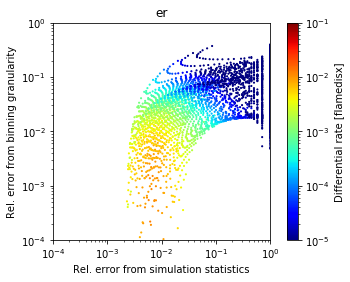

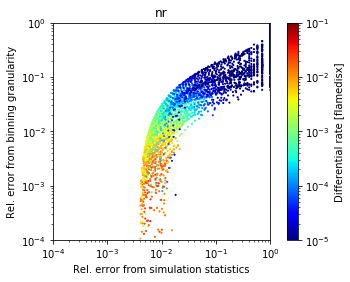

In [13]:
for dname, q in dsets.items():
    plt.scatter(q['stat_error'], q['binning_error'], marker='.', 
                c=q['fd_diff_rate'], 
                s=5,
                norm=matplotlib.colors.LogNorm(vmin=1e-5, vmax=1e-1), 
                cmap=plt.cm.jet)
    plt.colorbar(label='Differential rate [flamedisx]')
    plt.gca().set_aspect('equal')
    plt.xlabel("Rel. error from simulation statistics")
    plt.ylabel("Rel. error from binning granularity")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(1e-4, 1)
    plt.ylim(1e-4, 1)
    plt.title(dname)
    plt.show()

Simulation statistics is the dominant error source for most bins, but not for all.

In [14]:
with open('dsets_dump.pkl', mode='wb') as f:
    w = {dname: {k: v for k, v in q.items() if k not in ['source',]} 
         for dname, q in dsets.items()}
    pickle.dump(w, f)

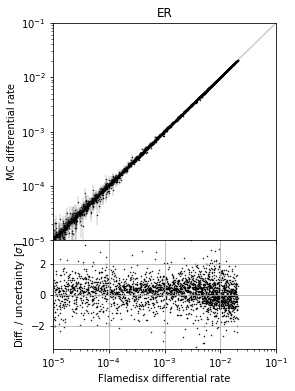

/home/aalbers/miniconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


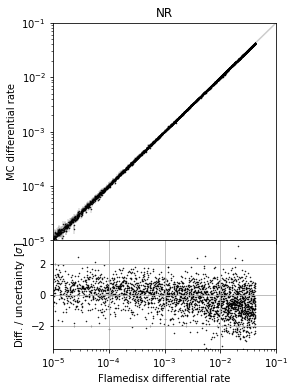

In [20]:
for dname, q in dsets.items():
    f, axes = plt.subplots(
        2, 1, 
        figsize=(4, 6), 
        sharex='col',
        gridspec_kw=dict(height_ratios=[2, 1]))

    xmin, xmax = 1e-5, 1e-1

    plt.sca(axes[0])
    plt.errorbar(q['fd_diff_rate'], 
                 q['mh_diff_rate'], 
                 yerr=q['total_error'] * q['mh_diff_rate'],
                 linestyle='', marker='.', markersize=1, #alpha=0.2, 
                 elinewidth=0.2, c='k')
    plt.plot([xmin, xmax], [xmin, xmax], c='k', alpha=0.2)

    plt.xscale('log')
    plt.xlim(xmin, xmax)

    plt.yscale('log')
    plt.ylim(xmin, xmax)
    plt.ylabel("MC differential rate")
    plt.title(dname.upper())

    plt.sca(axes[1])

    # residual = (diff_rate_mh - diff_rate_fd) / (np.diff(diff_rate_mh_interval, axis=0)/2)
    q['residual'] = ((q['mh_diff_rate'] - q['fd_diff_rate']) 
                     / (0.5 * (q['mh_diff_rate'] + q['fd_diff_rate']) * q['total_error']))
    plt.scatter(q['fd_diff_rate'], q['residual'],
                marker='.', c='k', s=1)

    plt.grid()

    plt.xscale('log')
    plt.xlim(xmin, xmax)
    plt.xlabel("Flamedisx differential rate")

    plt.ylim(-3.5, 3.5)
    plt.ylabel(r"Diff. / uncertainty [$\sigma$]")

    plt.subplots_adjust(hspace=0)
    plt.savefig(f'quantitative_comparison_{dname}.png', bbox_inches='tight', dpi=200)
    plt.show()

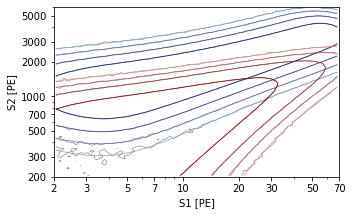

In [22]:
def histify(x):
    mh = t.differential_rate.similar_blank_histogram()
    mh.histogram = x.reshape(mh.histogram.shape)
    return mh

def colormap(*colors, discrete=False):
    """Return colormap that interpolates between colors.
    :param discrete: if True, return a discrete colormap
    (i.e. use nearest-neighbour rather than linear interpolation)
    """
    return matplotlib.colors.LinearSegmentedColormap.from_list(
        'CustomMap', colors, N=len(colors) if discrete else 256)

dsets['er']['colormap'] = colormap('midnightblue', 'lightblue')
dsets['nr']['colormap'] = colormap('maroon', 'pink')

for dname, q in dsets.items():
    # Flamedisx events per bin prediction
    q['fd_epb'] = q['fd_diff_rate'] / q['template'].events_to_diffrate.ravel()
    
    for ltype in ['fd', 'mh']:
        order = np.argsort(q[f'{ltype}_diff_rate'])
        restore_order = np.argsort(order)

        n = q[f'{ltype}_epb'].sum()

        q[f'{ltype}_density_fraction'] = (1 - np.cumsum(q[f'{ltype}_epb'][order]) / n)[restore_order]
        
# label_positions = None
golden_ratio = 1.61803398875
plt.figure(figsize=(5,  5 / golden_ratio))

for dname, q in dsets.items():
    for ltype in ['mh', 'fd']:
        mh = histify(q[f'{ltype}_density_fraction'])

        contour_levels = np.array([0.9, 0.99, 0.999, 0.9999]) * 100
        n_c = len(contour_levels)
        contours = plt.contour(mh.bin_centers(0), mh.bin_centers(1), 
                               100 * mh.histogram.T, 
                               #linestyles='solid',
                               alpha=0.8 if ltype == 'fd' else 1,
                               linewidths=1 if ltype == 'fd' else 0.3,
                               #alpha=1 if ltype == 'fd' else 0.5,
                               levels=contour_levels,
                               colors=q['colormap'](np.arange(n_c) / n_c) if ltype == 'fd' else 'k'
                              )
        #     labels = plt.clabel(contours, fmt='%g',
        #                         #manual=label_positions,
        #                         inline=False
        #                         #colors=['w'] * n_c if ltype =='fd' else None
        #                        )
        #     label_positions = [(l._x, l._y) for l in labels]

std_axes()
plt.tight_layout()
plt.savefig('fd_template_comparison.pdf', bbox_inches='tight')

Contours in (S1, S2) enclosing, from bright to faint colors, 50%, 99%, 99.9%, and 99.99% of events with the highest differential rates, for a 0-5 keV ER source (blue) and a 30 GeV/c^2 WIMP (red), at one position in the detector. The colored contours show the result from \fd, thin black lines the prediction from the 10^8 events  template (described in the text). This shows \fd~agrees with the template deep into the tails of the distribution, until the template becomes unreliable due to statistical errors.